In [360]:
from pandas_profiling import ProfileReport
import pandas as pd
import os
from sql.core import PostgreSQLSession
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from scipy.special import logit, expit
import seaborn as sns
import optuna

In [2]:
path = os.path.join(os.getcwd(), "data")

for file_name in os.listdir(path):
    if file_name.endswith(".csv"):
        full_path = os.path.join(path, file_name)
        var_name, _ = file_name.split(".")
        locals()[var_name] = pd.read_csv(full_path)
        print(f"{full_path} processed.")

/home/azureuser/notebooks/data/item_dict_train.csv processed.
/home/azureuser/notebooks/data/features_1.csv processed.
/home/azureuser/notebooks/data/features_2.csv processed.
/home/azureuser/notebooks/data/uplift.csv processed.
/home/azureuser/notebooks/data/als_model_ratings.csv processed.
/home/azureuser/notebooks/data/user_dict_train.csv processed.
/home/azureuser/notebooks/data/offers_valid.csv processed.
/home/azureuser/notebooks/data/sample_submission.csv processed.
/home/azureuser/notebooks/data/offers.csv processed.
/home/azureuser/notebooks/data/checks.csv processed.
/home/azureuser/notebooks/data/hierarchy.csv processed.
/home/azureuser/notebooks/data/offers_train.csv processed.
/home/azureuser/notebooks/data/checks_train.csv processed.
/home/azureuser/notebooks/data/ALS_data_train.csv processed.


In [3]:
def sql_query(query):
    with PostgreSQLSession(
        server="127.0.0.1",
        port=5432,
        db="postgres",
        user="postgres",
        password="12345",
        silent=True
    ) as pg:
        return pg.select_statement(query)

In [437]:
features1 = sql_query("select * from datamart.offer_features1")

In [438]:
features2 = sql_query("select * from datamart.offer_features2")

In [439]:
features3 = sql_query("select * from datamart.avg_money_spent_on_offer")

In [440]:
features4 = sql_query("select * from datamart.sum_money_spent_on_offer")

In [441]:
Xy = features1.merge(features2, on="Offer_ID").merge(features3).merge(features4).merge(offers[["Offer_ID", "Promo_type"]].drop_duplicates()).merge(uplift).set_index("Offer_ID")
Xy.fillna(Xy["std_price"].mean(), inplace=True)

In [442]:
no_carantine_offers = offers[["Offer_ID", "start_date"]].drop_duplicates()
no_carantine_offers = no_carantine_offers.loc[~no_carantine_offers["start_date"].between('2020-03-01', '2020-04-30')].set_index("Offer_ID").drop(columns="start_date")

In [443]:
# Xy = Xy.merge(no_carantine_offers, left_index=True, right_index=True)

In [444]:
X_test = features1.merge(features2, on="Offer_ID").merge(features3).merge(features4).merge(offers[["Offer_ID", "Promo_type"]].drop_duplicates()).merge(sample_submission[["Offer_ID"]]).set_index("Offer_ID").reindex(list(sample_submission["Offer_ID"]))
X_test["Promo_type"] = pd.Series(X_test["Promo_type"], dtype="category")

In [445]:
Xy_valid = Xy.merge(offers_valid[["Offer_ID"]].drop_duplicates(), left_index=True, right_on="Offer_ID").drop(columns="Offer_ID")
Xy_train = Xy.merge(offers_train[["Offer_ID"]].drop_duplicates(), left_index=True, right_on="Offer_ID").drop(columns="Offer_ID")

In [446]:
# with PostgreSQLSession(
#         server="127.0.0.1",
#         port=5432,
#         db="postgres",
#         user="postgres",
#         password="12345",
#         silent=True
# ) as pg:
#     pg.df_to_db(calendar, "public.calendar", if_exists="replace")

In [447]:
X_valid, y_valid = Xy_valid.drop(columns="UpLift"), Xy_valid["UpLift"]
X_train, y_train = Xy_train.drop(columns="UpLift"), Xy_train["UpLift"]

X_valid["Promo_type"] = pd.Series(X_valid["Promo_type"], dtype="category")
X_train["Promo_type"] = pd.Series(X_train["Promo_type"], dtype="category")

In [448]:
Xy = pd.concat([
    Xy,
    Xy.loc[Xy["Promo_type"] == "Facades"].sample(60)
])

Xy = pd.concat([
    Xy,
    Xy.loc[Xy["Promo_type"] == "Billboards"].sample(30)
])

In [449]:
X, y = Xy.drop(columns="UpLift"), Xy["UpLift"]
X["Promo_type"] = pd.Series(X["Promo_type"], dtype="category")

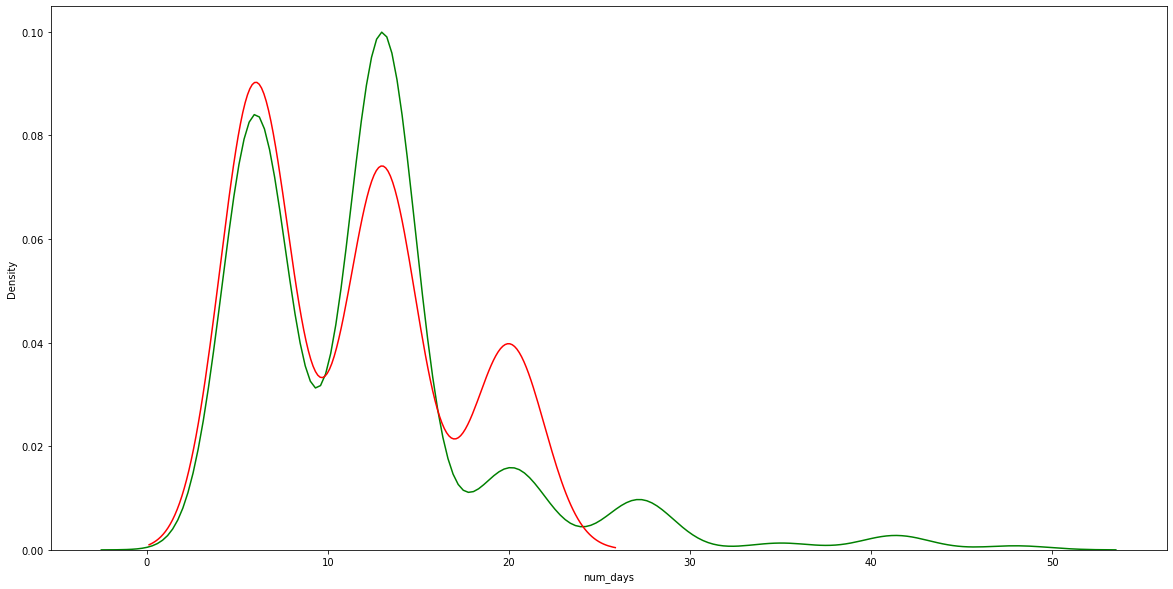

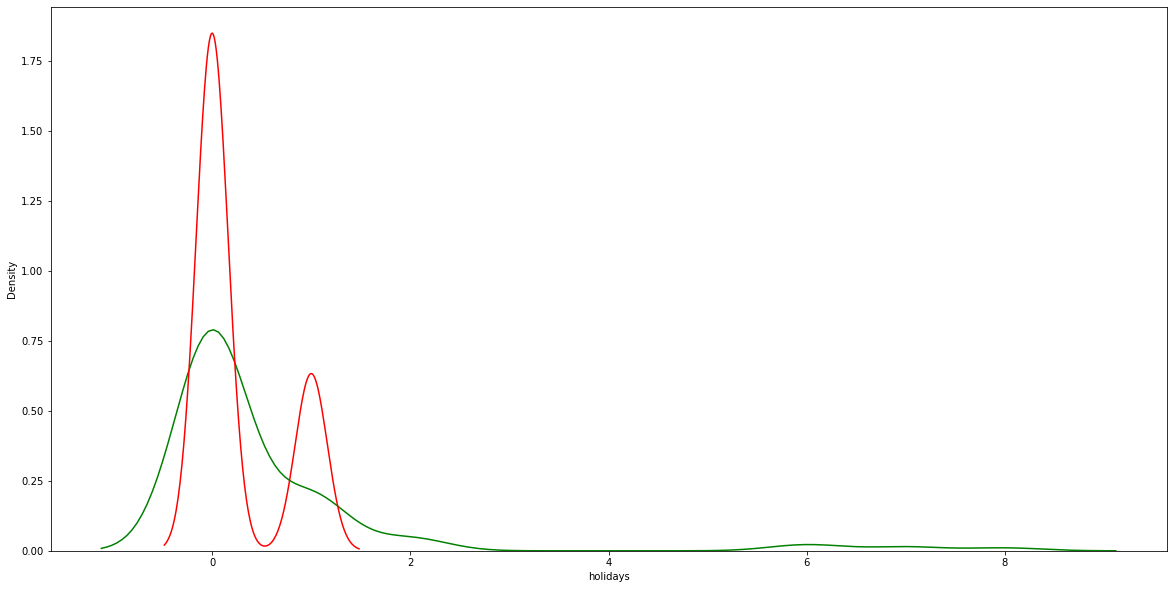

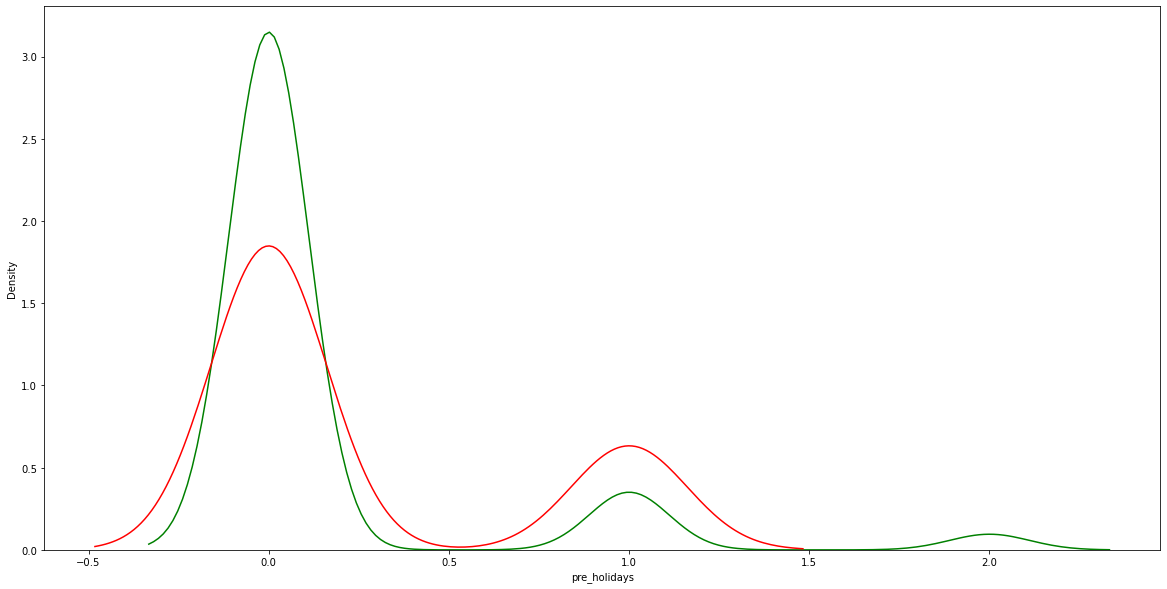

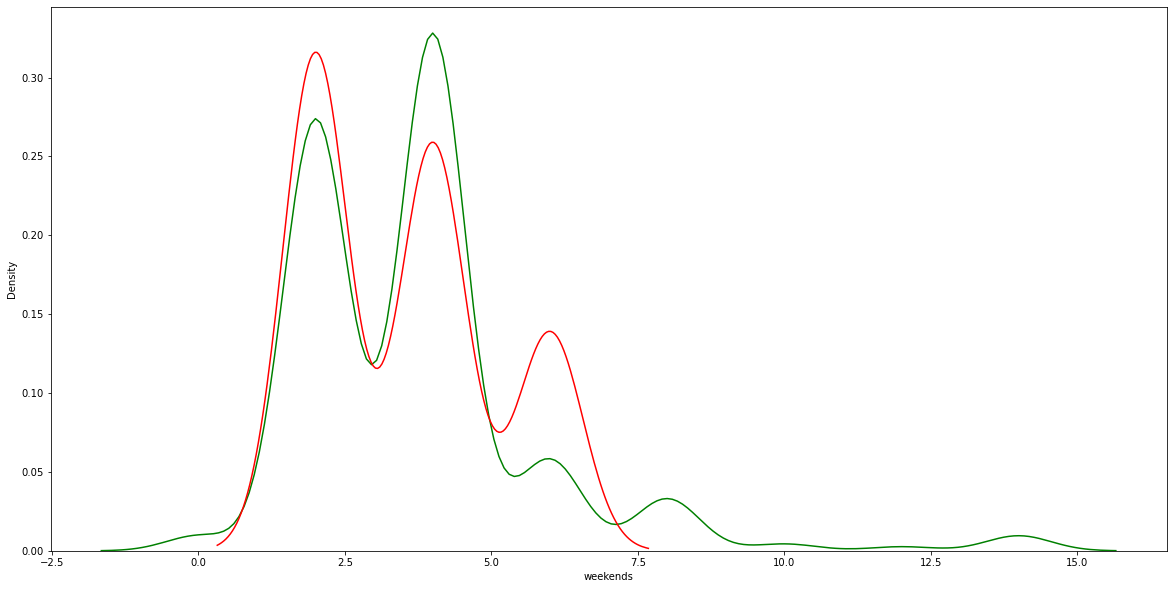

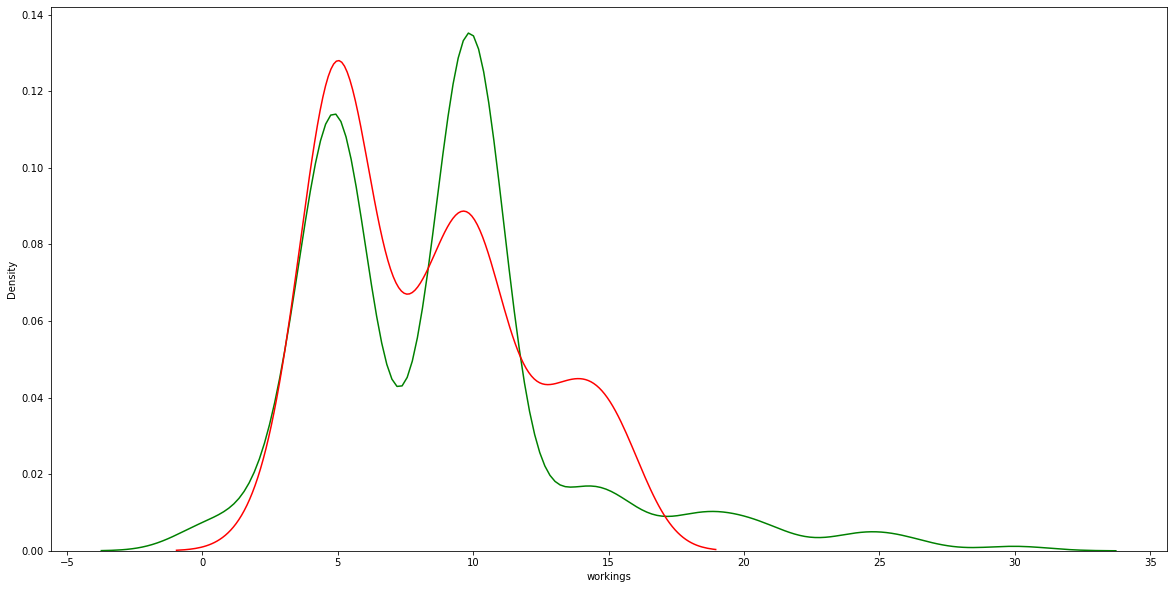

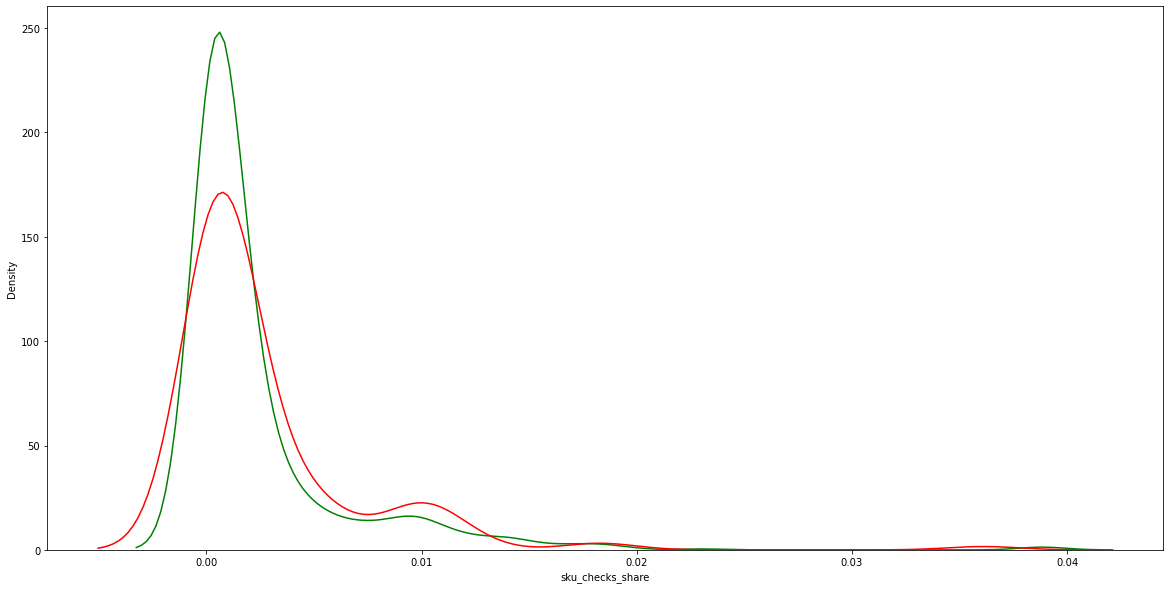

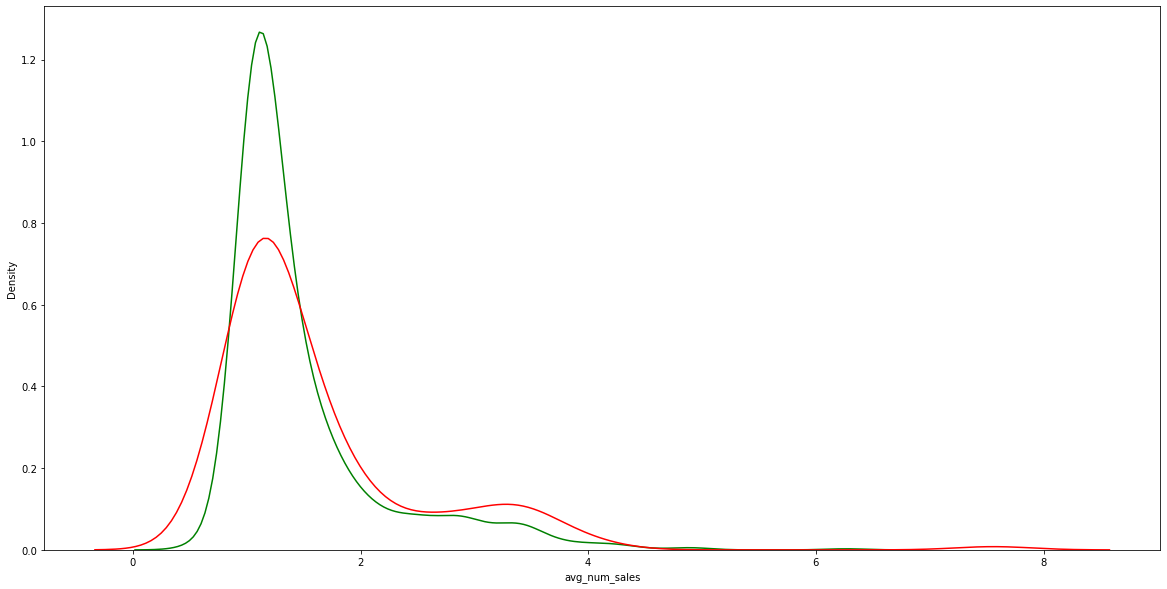

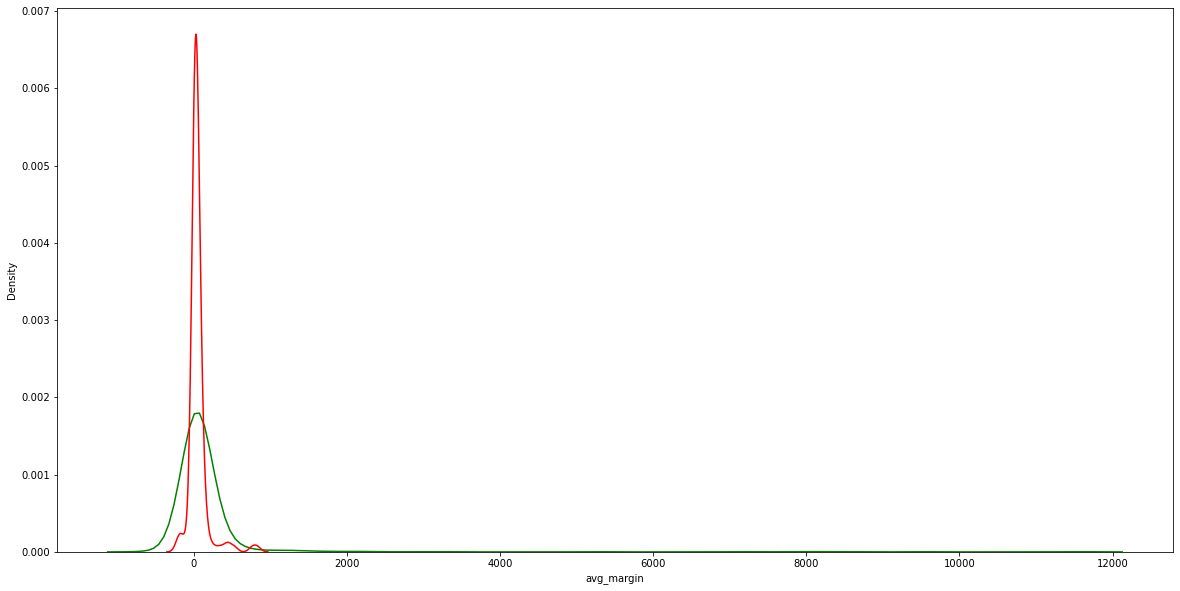

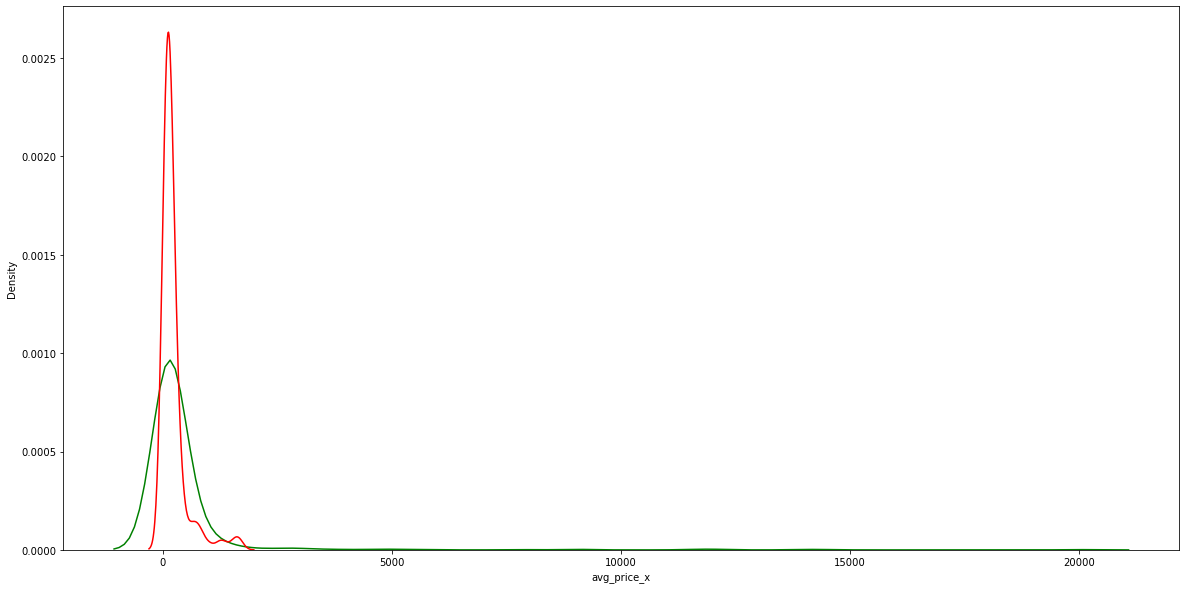

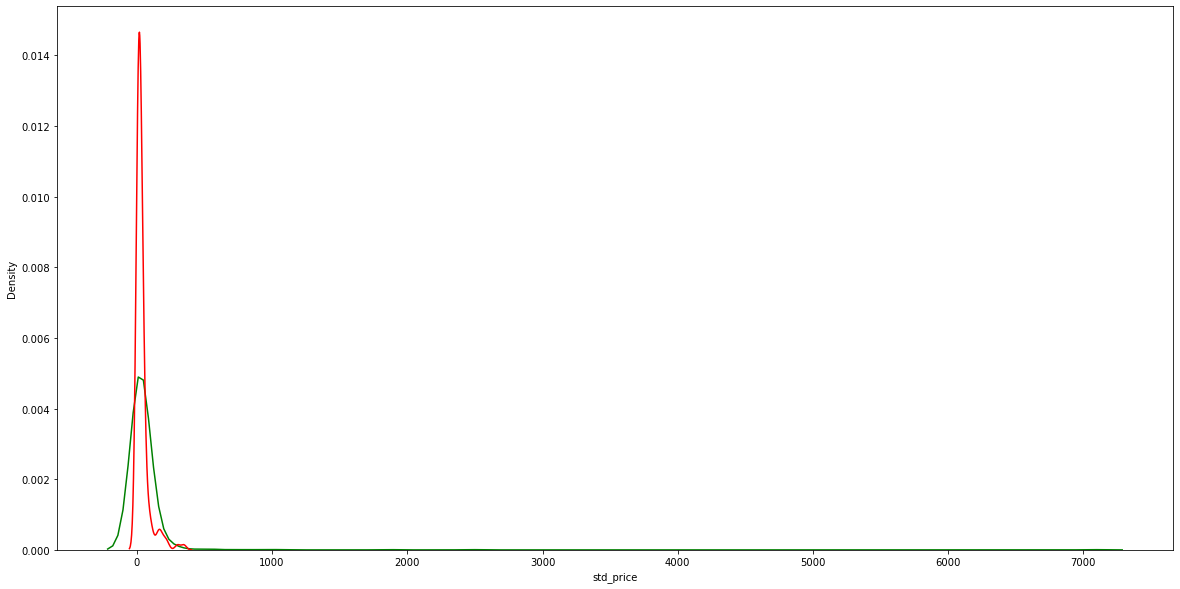

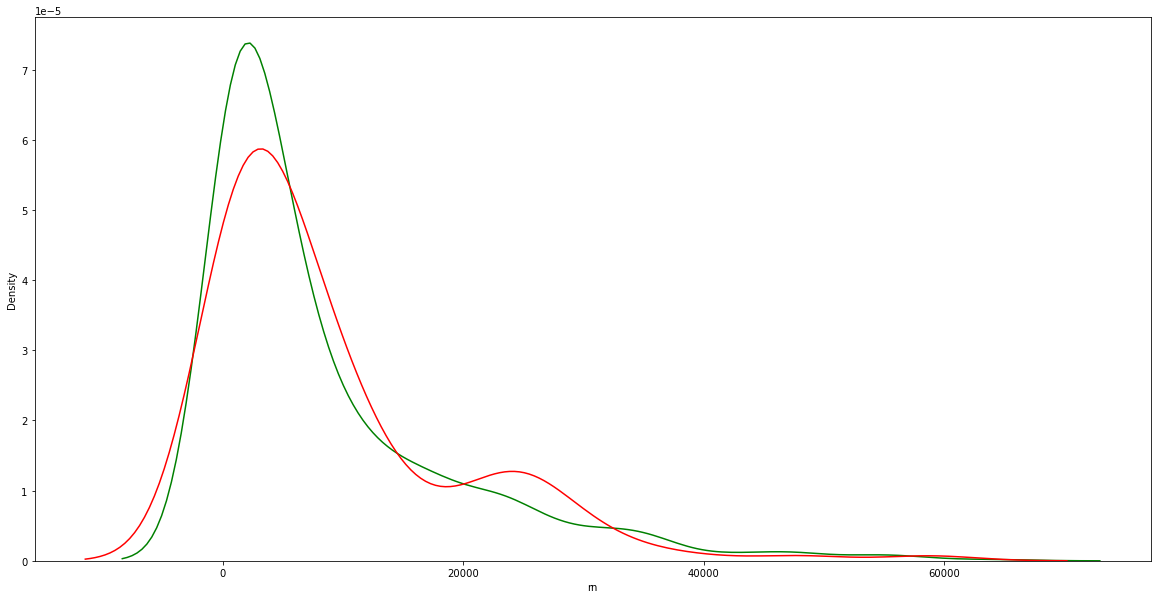

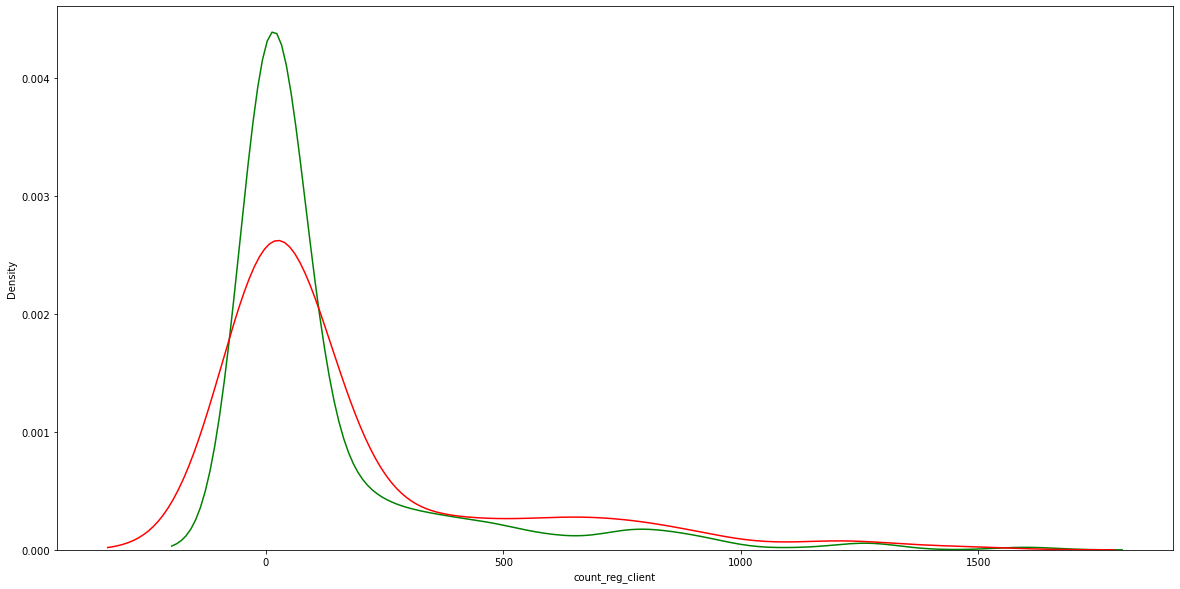

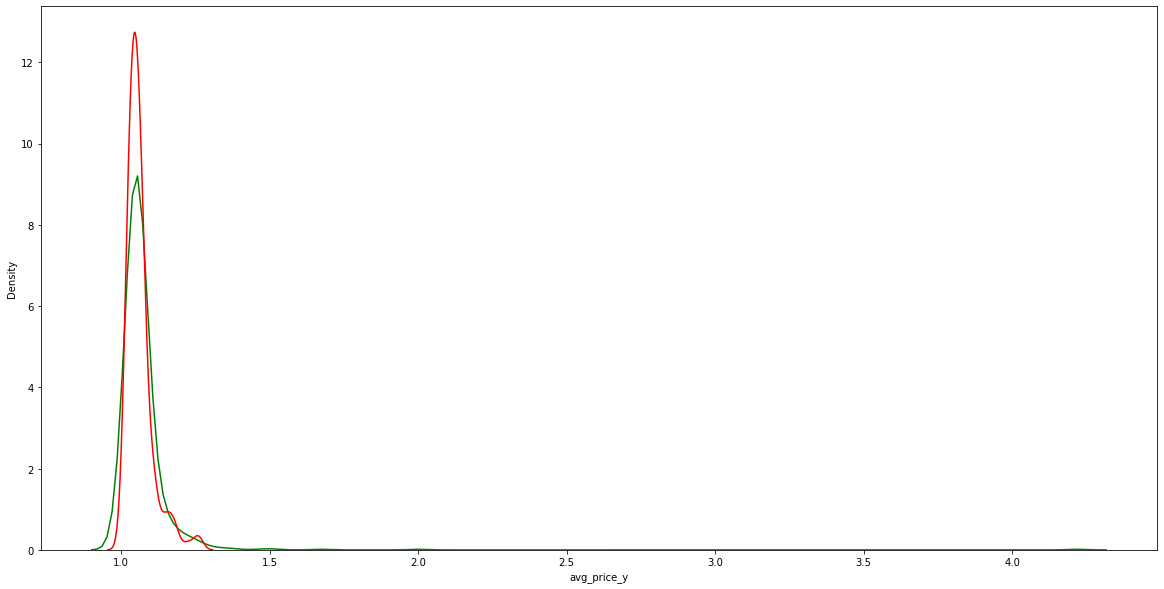

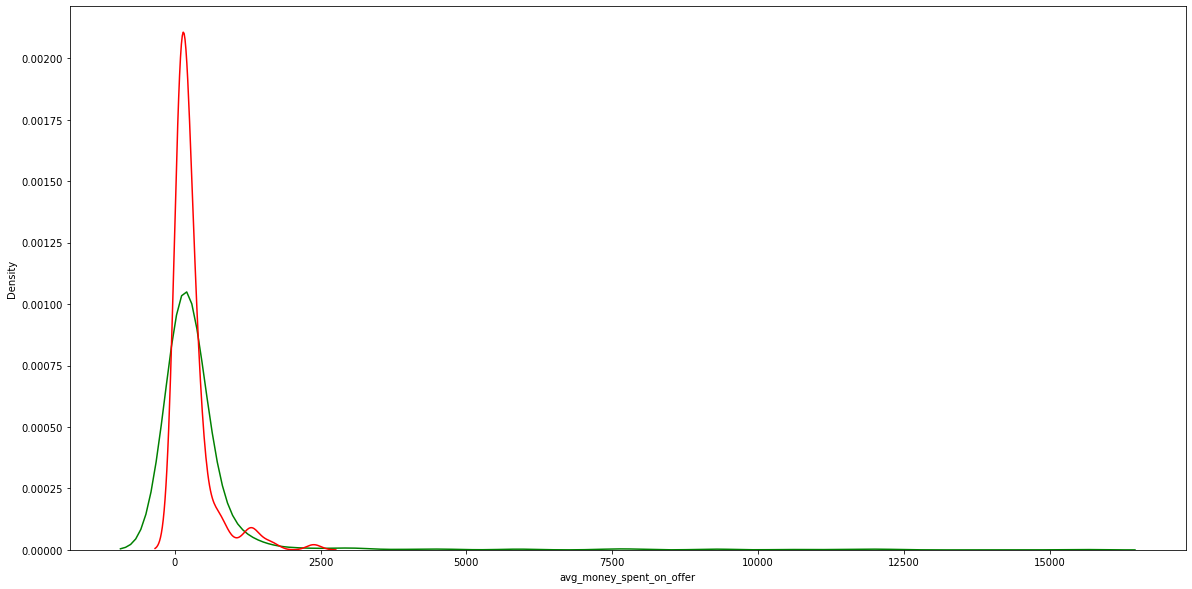

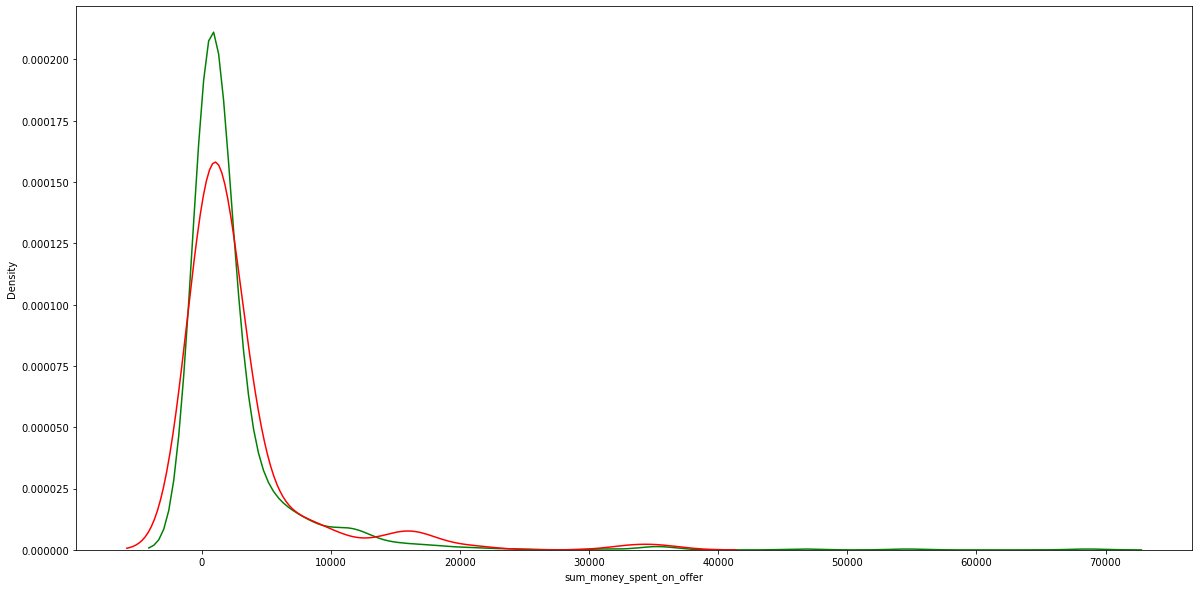

In [450]:
for col in X_train:
    if col != "Promo_type":
        plt.figure(figsize=(20, 10))
        sns.kdeplot(X[col], color="green")
        sns.kdeplot(X_test[col], color="red")
        plt.show()

In [451]:
X["Promo_type"].value_counts() / X["Promo_type"].count()

Facades       0.313253
Biweekly      0.278313
Seasonal      0.254217
Billboards    0.154217
Name: Promo_type, dtype: float64

In [452]:
X_test["Promo_type"].value_counts() / X_test["Promo_type"].count()

Facades       0.342282
Biweekly      0.275168
Seasonal      0.221477
Billboards    0.161074
Name: Promo_type, dtype: float64

In [327]:
# ProfileReport(X_train).to_notebook_iframe()

In [483]:
X_train.head()

,num_days,Promo_type,holidays,pre_holidays,weekends,workings,sku_checks_share,avg_num_sales,avg_margin,avg_price_x,std_price,rn,count_reg_client,avg_price_y,avg_money_spent_on_offer,sum_money_spent_on_offer
1870,13,Biweekly,0,0,4,10,0.000774,1.548722,17.617951,50.486495,10.615731,3465.875000,16.0,1.062265,77.678315,621.426524
826,13,Seasonal,0,0,4,10,0.002134,0.652465,83.397863,265.792175,34.562678,2304.000000,9.0,1.024767,175.857478,175.857478
659,13,Seasonal,0,0,4,10,0.000801,1.044632,74.927752,143.608189,17.776957,3797.909091,54.0,1.030990,149.500935,1644.510284
1277,13,Seasonal,0,0,4,10,0.001142,1.671030,17.203015,89.602496,15.702418,736.000000,18.0,1.034287,155.100343,155.100343
879,13,Seasonal,0,0,4,10,0.002847,1.217883,138.601037,288.316755,19.541782,630.500000,114.0,1.010801,359.478076,718.956153


In [495]:
.columns[:2][np.array([1, 1]).astype(bool)]

Index(['num_days', 'Promo_type'], dtype='object')

In [498]:
def objective(trial):
    params = np.array([trial.suggest_int(col, 0, 1) for col in X_train]).astype(bool)
    upper_clip = trial.suggest_float("clip", 15, 25)
    features = X_train.columns[params]
    cat_features = ["Promo_type"] if "Promo_type" in features else None
    
    reg = CatBoostRegressor(loss_function="MAE", eval_metric="MAE", early_stopping_rounds=50)
    reg.fit(X_train[features], y_train.clip(upper=upper_clip), cat_features=cat_features, eval_set=(X_valid[features], y_valid), verbose=False)
    
    return mean_absolute_error(reg.predict(X_valid[features]), y_valid)

In [500]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2021-06-06 05:18:49,098] A new study created in memory with name: no-name-2a09e66c-e83f-44e2-8826-95d34e67f5ea
[I 2021-06-06 05:18:52,854] Trial 0 finished with value: 3.2034884584966927 and parameters: {'num_days': 0, 'Promo_type': 1, 'holidays': 0, 'pre_holidays': 0, 'weekends': 1, 'workings': 1, 'sku_checks_share': 0, 'avg_num_sales': 1, 'avg_margin': 1, 'avg_price_x': 1, 'std_price': 1, 'rn': 1, 'count_reg_client': 1, 'avg_price_y': 0, 'avg_money_spent_on_offer': 0, 'sum_money_spent_on_offer': 1, 'clip': 17.819062581890396}. Best is trial 0 with value: 3.2034884584966927.
[I 2021-06-06 05:18:55,921] Trial 1 finished with value: 3.22562700350114 and parameters: {'num_days': 0, 'Promo_type': 1, 'holidays': 1, 'pre_holidays': 0, 'weekends': 1, 'workings': 0, 'sku_checks_share': 0, 'avg_num_sales': 1, 'avg_margin': 1, 'avg_price_x': 1, 'std_price': 0, 'rn': 1, 'count_reg_client': 1, 'avg_price_y': 0, 'avg_money_spent_on_offer': 0, 'sum_money_spent_on_offer': 1, 'clip': 15.4403971036

In [593]:
*feature_mask, upper_clip = study.best_params.values()
features = list(X_train.columns[np.array(feature_mask).astype(bool)])

In [594]:
features

['num_days',
 'pre_holidays',
 'count_reg_client',
 'avg_price_y',
 'avg_money_spent_on_offer',
 'sum_money_spent_on_offer']

In [595]:
features = list(set(X_train)) # - set(["weekends", "holidays", "pre_holidays", "workings"]))

In [596]:
upper_clip = 20

In [598]:
reg = CatBoostRegressor(loss_function="MAE", eval_metric="MAE", early_stopping_rounds=50)
reg.fit(
    X_train[features], y_train.clip(upper=upper_clip), 
    cat_features=["Promo_type"] if "Promo_type" in features else None, 
    eval_set=(X_valid[features], y_valid), 
    verbose=50
)

0:	learn: 5.4534795	test: 4.6843712	best: 4.6843712 (0)	total: 24.5ms	remaining: 24.4s
50:	learn: 3.5105326	test: 3.2426199	best: 3.2398264 (48)	total: 1.03s	remaining: 19.2s
100:	learn: 3.0475780	test: 3.0727482	best: 3.0727482 (100)	total: 2.07s	remaining: 18.5s
150:	learn: 2.8087319	test: 3.0445900	best: 3.0406478 (149)	total: 3.04s	remaining: 17.1s
200:	learn: 2.6103966	test: 3.0020824	best: 2.9995856 (199)	total: 3.99s	remaining: 15.9s
250:	learn: 2.4362061	test: 3.0080152	best: 2.9981919 (202)	total: 4.95s	remaining: 14.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.998191938
bestIteration = 202

Shrink model to first 203 iterations.


In [543]:
reg = LGBMRegressor(objective="mae", n_estimators=92)
reg.fit(X_train[features], y_train.clip(upper=upper_clip), eval_set=(X_valid[features], y_valid), verbose=1)

[1]	valid_0's l1: 3.74647
[2]	valid_0's l1: 3.62111
[3]	valid_0's l1: 3.54521
[4]	valid_0's l1: 3.50378
[5]	valid_0's l1: 3.477
[6]	valid_0's l1: 3.42093
[7]	valid_0's l1: 3.34834
[8]	valid_0's l1: 3.30065
[9]	valid_0's l1: 3.27702
[10]	valid_0's l1: 3.24545
[11]	valid_0's l1: 3.22631
[12]	valid_0's l1: 3.22275
[13]	valid_0's l1: 3.17723
[14]	valid_0's l1: 3.16531
[15]	valid_0's l1: 3.15437
[16]	valid_0's l1: 3.11097
[17]	valid_0's l1: 3.10577
[18]	valid_0's l1: 3.08288
[19]	valid_0's l1: 3.0847
[20]	valid_0's l1: 3.0811
[21]	valid_0's l1: 3.0743
[22]	valid_0's l1: 3.06128
[23]	valid_0's l1: 3.0532
[24]	valid_0's l1: 3.04743
[25]	valid_0's l1: 3.03267
[26]	valid_0's l1: 3.04449
[27]	valid_0's l1: 3.05203
[28]	valid_0's l1: 3.04835
[29]	valid_0's l1: 3.03532
[30]	valid_0's l1: 3.03264
[31]	valid_0's l1: 3.02465
[32]	valid_0's l1: 3.01408
[33]	valid_0's l1: 3.01209
[34]	valid_0's l1: 3.01252
[35]	valid_0's l1: 3.00109
[36]	valid_0's l1: 2.99994
[37]	valid_0's l1: 2.99399
[38]	valid_0's l

LGBMRegressor(n_estimators=92, objective='mae')

In [534]:
reg = CatBoostRegressor(loss_function="MAE", eval_metric="MAE", iterations=reg._tree_count, learning_rate=reg._learning_rate)
reg.fit(
    X[features], 
    y.clip(upper=upper_clip), 
    cat_features=["Promo_type"] if "Promo_type" in features else None, 
    eval_set=(X_valid[features], y_valid), 
    verbose=50
)

0:	learn: 4.9355420	test: 4.6670843	best: 4.6670843 (0)	total: 29.6ms	remaining: 11.3s
50:	learn: 3.2220110	test: 3.0875631	best: 3.0875631 (50)	total: 1.15s	remaining: 7.52s
100:	learn: 2.8854301	test: 2.8057030	best: 2.8057030 (100)	total: 2.26s	remaining: 6.36s
150:	learn: 2.7142209	test: 2.6137781	best: 2.6137781 (150)	total: 3.34s	remaining: 5.17s
200:	learn: 2.5797115	test: 2.4655260	best: 2.4655260 (200)	total: 4.45s	remaining: 4.07s
250:	learn: 2.4625487	test: 2.3347855	best: 2.3347855 (250)	total: 5.59s	remaining: 2.98s
300:	learn: 2.3616185	test: 2.2119323	best: 2.2119323 (300)	total: 6.77s	remaining: 1.89s
350:	learn: 2.2735820	test: 2.1255088	best: 2.1255088 (350)	total: 8.02s	remaining: 777ms
384:	learn: 2.2251922	test: 2.0847941	best: 2.0847941 (384)	total: 8.83s	remaining: 0us

bestTest = 2.084794111
bestIteration = 384



In [544]:
sample_submission["UpLift"] = reg.predict(X_test[features])

In [577]:
sample_submission.to_csv("submissions/winner_submission_10.csv", index=False)

In [642]:
feature_importance = reg.get_feature_importance(prettified=True)

feature_importance["Название"] = feature_importance["Feature Id"].map({
    'Promo_type': 'Признаки кампании',
    'avg_price_y': 'Признаки продуктов',
 'sum_money_spent_on_offer': 'Признаки клиентов',
 'rn': 'Признаки продуктов',
 'avg_margin': 'Признаки продуктов',
 'avg_num_sales': 'Признаки продуктов',
 'avg_money_spent_on_offer': 'Признаки клиентов',
 'std_price': 'Признаки продуктов',
 'sku_checks_share': 'Признаки продуктов',
 'count_reg_client': 'Признаки клиентов',
 'avg_price_x': 'Признаки продуктов',
 'weekends': 'Признаки времени',
 'num_days': 'Признаки времени',
 'workings': 'Признаки времени',
 'holidays': 'Признаки времени',
 'pre_holidays': 'Признаки времени'
})

feature_importances = feature_importance.groupby("Название")["Importances"].sum().reset_index().sort_values("Название", ascending=False).rename(columns={"Importances": "Значимость, %"})

In [643]:
feature_importances

,Название,"Значимость, %"
3,Признаки продуктов,52.224977
2,Признаки клиентов,22.219458
1,Признаки кампании,11.742045
0,Признаки времени,13.813521


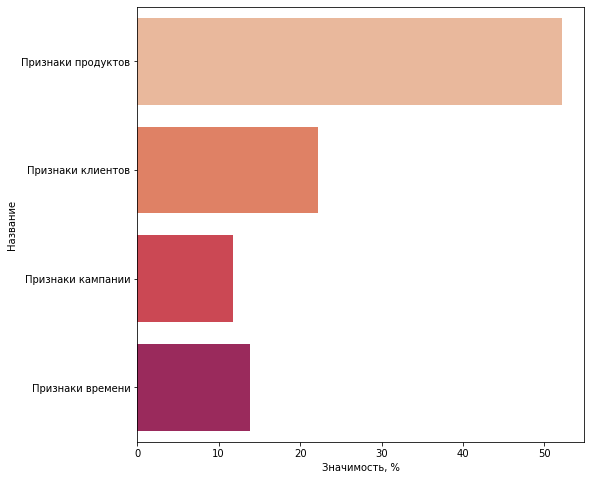

In [645]:
plt.figure(figsize=(8, 8))
sns.barplot(data=feature_importances, x="Значимость, %", y="Название", palette=sns.color_palette("rocket_r"));
plt.show()

In [601]:
X_test

,num_days,Promo_type,holidays,pre_holidays,weekends,workings,sku_checks_share,avg_num_sales,avg_margin,avg_price_x,std_price,rn,count_reg_client,avg_price_y,avg_money_spent_on_offer,sum_money_spent_on_offer
Offer_ID,,,,,,,,,,,,,,,,
386,20,Biweekly,0,0,6,15,0.001426,0.695832,156.715410,352.693865,81.165899,2291.000000,2.0,1.061453,256.719782,256.719782
182,13,Biweekly,0,0,4,10,0.001050,1.301087,11.382761,37.651132,5.520700,1899.133333,112.0,1.042548,47.045978,705.689674
173,13,Biweekly,0,0,4,10,0.000562,1.086703,97.223822,222.231112,38.243497,23569.800000,2.0,1.172266,241.691228,1208.456139
375,20,Biweekly,0,0,6,15,0.000802,1.039630,46.639550,122.294160,19.901747,6886.750000,30.0,1.054638,122.255112,1467.061342
379,20,Biweekly,0,0,6,15,0.000302,1.039086,42.975754,373.900313,56.386101,10305.615385,1.0,1.027472,393.108678,5110.412820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,13,Biweekly,1,1,4,8,0.000495,1.042613,-85.627579,169.090429,23.855361,9588.357143,10.0,1.039361,178.667295,2501.342135
99,13,Seasonal,0,0,4,10,0.000124,1.127655,20.224890,101.039313,18.732852,22497.113924,5.0,1.063688,117.256146,9263.235531
100,13,Seasonal,0,0,4,10,0.000229,1.144786,13.002920,223.960321,49.127956,19472.083333,3.0,1.070782,247.584174,2971.010093
